In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pennylane as qml
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from quantum_layer import quantum_layer

# Heat PDE for 2D with given BC and initial condition to predict at different time steps


The 2D heat equation is given by $$\frac{\partial u}{\partial t} = \alpha(\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})$$

In [2]:
num_points = 500 # Number of randomly sampled points for IC and BC
alpha = 15 # thermal diffusivity

# Define the range for time and spatial dimensions
t_min, t_max = 0, 1
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Generate random samples for the spatial and temporal ranges
x_samples = np.random.rand(num_points)
y_samples = np.random.rand(num_points)
t_samples = np.random.rand(num_points)

zeros = np.zeros(num_points)
ones = np.ones(num_points)

# [x, y, t, T]
 # Boundary top: u(x, y=1, t) = 100
boundary_top = np.vstack([x_samples, ones, t_samples, ones*100]).T
# Boundary right: u(x=1, y, t) = 0
boundary_right = np.vstack([ones, y_samples, t_samples, zeros]).T 
 # Boundary bottom: u(x, y=0, t) = 0
boundary_bottom = np.vstack([x_samples, zeros, t_samples,  zeros]).T
# Boundary left: u(x=0, y0, t) = 0
boundary_left = np.vstack([zeros, y_samples, t_samples, zeros]).T 
# IC u(x, y, t=0) = 0
initial_condition = np.vstack([x_samples, y_samples, zeros, zeros]).T 

initial_boundary_conditions = np.vstack([boundary_top, boundary_right, boundary_bottom, boundary_left, initial_condition])

x_initial_bc = initial_boundary_conditions[:, 0].astype(np.float32)
y_initial_bc = initial_boundary_conditions[:, 1].astype(np.float32)
t_initial_bc = initial_boundary_conditions[:, 2].astype(np.float32)
u_initial_bc = initial_boundary_conditions[:, 3].astype(np.float32)

In [4]:
def loss_pde(x, y, t, net):
    # Convert inputs to tensors
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    # print(x.shape)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)
        
        inputs = tf.stack([x, y, t], axis=1)
        u = net(inputs)
        
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_y = tape.gradient(u, y)
        u_yy = tape.gradient(u_y, y)

    loss_pde = tf.reduce_mean((u_t - alpha * (u_xx + u_yy)) ** 2)
    
    del tape  # Explicitly delete the tape to release resources
    # print(loss_pde.dtype)
    return loss_pde
def ic_bc_loss(x, y, t, net, u_initial_bc):
    
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    inputs = tf.stack([x, y, t], axis=1)
    u_initial_bc = tf.constant(u_initial_bc, dtype=tf.float32)

    u_predicted_initial = net(inputs)
    mse_loss = tf.keras.losses.MeanSquaredError()
    loss_ic_bc = mse_loss(u_predicted_initial, u_initial_bc)
    # print(u_initial_bc.dtype)

    return loss_ic_bc

# Quantum Case 

## Circuit 1

In [7]:
def complex_to_real(x):
    return tf.concat([tf.math.real(x), tf.math.imag(x)], axis=-1)


In [8]:
qlayer = quantum_layer(4, circuit_number='1')

NNQ1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    qlayer,
    tf.keras.layers.Lambda(complex_to_real),  # Lambda layer to split complex numbers
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NNQ1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                128       
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                                 
 keras_layer_1 (KerasLayer)  (None, 4)                 8         
                                                                 
 lambda (Lambda)             (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
 dense_12 (Dense)            (None, 1)                

Epoch 0: Average Loss = 2003.994140625
Epoch 10: Average Loss = 1955.8251953125
Epoch 20: Average Loss = 1939.4326171875
Epoch 30: Average Loss = 1912.8343505859375
Epoch 40: Average Loss = 1886.477294921875
Epoch 50: Average Loss = 1875.0172119140625
Epoch 60: Average Loss = 1867.41796875
Epoch 70: Average Loss = 1852.6956787109375
Epoch 80: Average Loss = 1842.4595947265625
Epoch 90: Average Loss = 1820.515625
Epoch 100: Average Loss = 1809.731201171875
Epoch 110: Average Loss = 1805.3486328125
Epoch 120: Average Loss = 1798.6627197265625
Epoch 130: Average Loss = 1785.249267578125
Epoch 140: Average Loss = 1772.553466796875
Epoch 150: Average Loss = 1766.7113037109375
Epoch 160: Average Loss = 1764.387939453125
Epoch 170: Average Loss = 1761.3433837890625
Epoch 180: Average Loss = 1756.5185546875
Epoch 190: Average Loss = 1746.859619140625
Epoch 200: Average Loss = 1739.529052734375
Epoch 210: Average Loss = 1738.5244140625
Epoch 220: Average Loss = 1731.6275634765625
Epoch 230: Ave

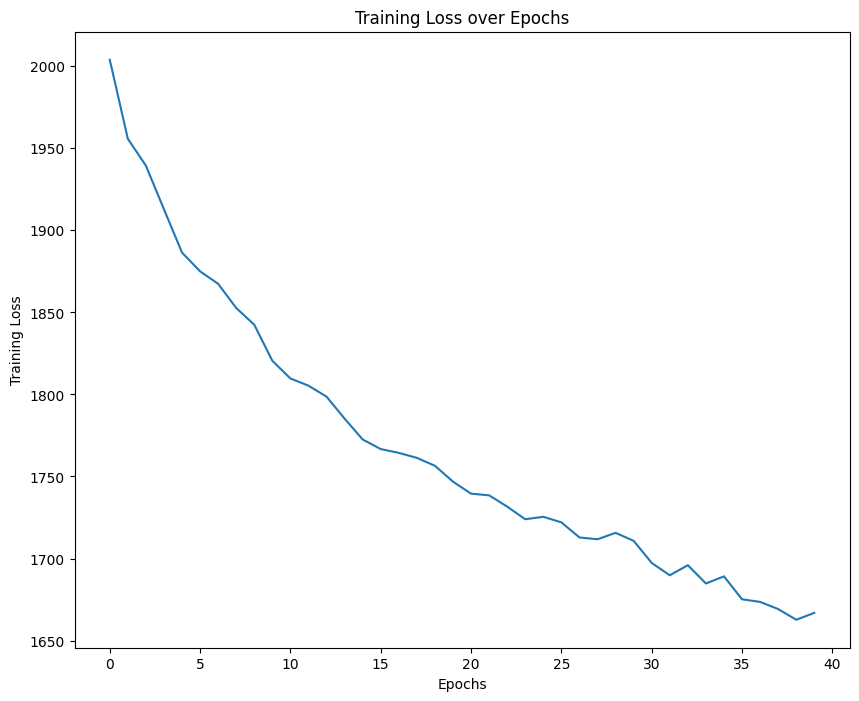

In [9]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.0005)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []
num_epochs = 400
batch_size = 256
num_batches = num_points // batch_size

## batching is done in order to make the training more effecient 
dataset = tf.data.Dataset.from_tensor_slices((x_initial_bc, y_initial_bc, t_initial_bc, u_initial_bc))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Training loop
for itr in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataset:
        x_batch, y_batch, t_batch, u_batch = batch
        with tf.GradientTape() as tape:
            train_loss = loss_pde(x_batch, y_batch, t_batch, NNQ1) + ic_bc_loss(x_batch, y_batch, t_batch, NNQ1, u_batch)
        
        grad_w = tape.gradient(train_loss, NNQ1.trainable_variables)
        optm.apply_gradients(zip(grad_w, NNQ1.trainable_variables))
        
        # Accumulate the loss for each batch
        epoch_loss += train_loss
        num_batches += 1
    
    # Compute the average loss over all batches
    epoch_loss /= num_batches
    
    if itr % 10 == 0:
        train_loss_record.append(epoch_loss)
        print(f"Epoch {itr}: Average Loss = {epoch_loss.numpy()}")

plt.figure(figsize = (10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

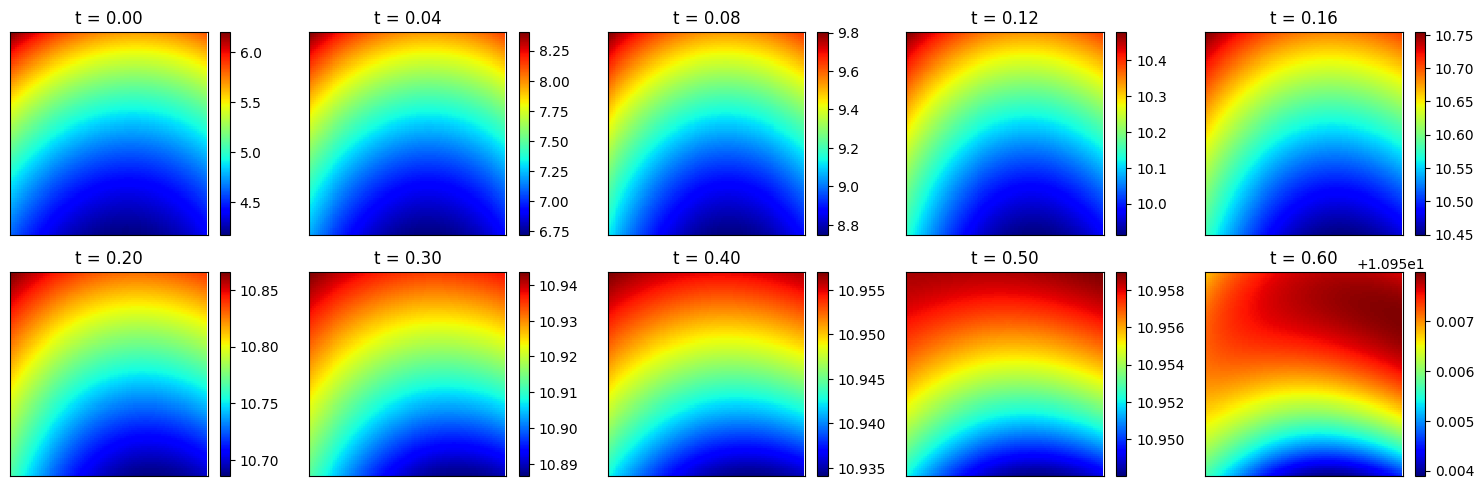

In [10]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
# NN= NNClassical
# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NNQ1(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()

## Circuit 6

In [12]:
qlayer6 = quantum_layer(n_qubits = 4, circuit_number='6')

NNQ6 = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    qlayer6,
    tf.keras.layers.Lambda(complex_to_real),  # Lambda layer to split complex numbers
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NNQ6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                128       
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 4)                 132       
                                                                 
 keras_layer_2 (KerasLayer)  (None, 4)                 28        
                                                                 
 lambda_1 (Lambda)           (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                                 
 dense_17 (Dense)            (None, 1)                

Epoch 0: Average Loss = 1944.8740234375
Epoch 10: Average Loss = 1923.997314453125
Epoch 20: Average Loss = 1925.1591796875
Epoch 30: Average Loss = 1903.2744140625
Epoch 40: Average Loss = 1905.1536865234375
Epoch 50: Average Loss = 1891.6708984375
Epoch 60: Average Loss = 1882.2855224609375
Epoch 70: Average Loss = 1867.835205078125
Epoch 80: Average Loss = 1863.981689453125
Epoch 90: Average Loss = 1851.6123046875
Epoch 100: Average Loss = 1853.9908447265625
Epoch 110: Average Loss = 1846.701171875
Epoch 120: Average Loss = 1838.6031494140625
Epoch 130: Average Loss = 1833.986328125
Epoch 140: Average Loss = 1816.5797119140625
Epoch 150: Average Loss = 1812.4378662109375
Epoch 160: Average Loss = 1795.570556640625
Epoch 170: Average Loss = 1804.658447265625
Epoch 180: Average Loss = 1795.651123046875
Epoch 190: Average Loss = 1793.1865234375
Epoch 200: Average Loss = 1788.7269287109375
Epoch 210: Average Loss = 1774.915771484375
Epoch 220: Average Loss = 1775.992919921875
Epoch 230:

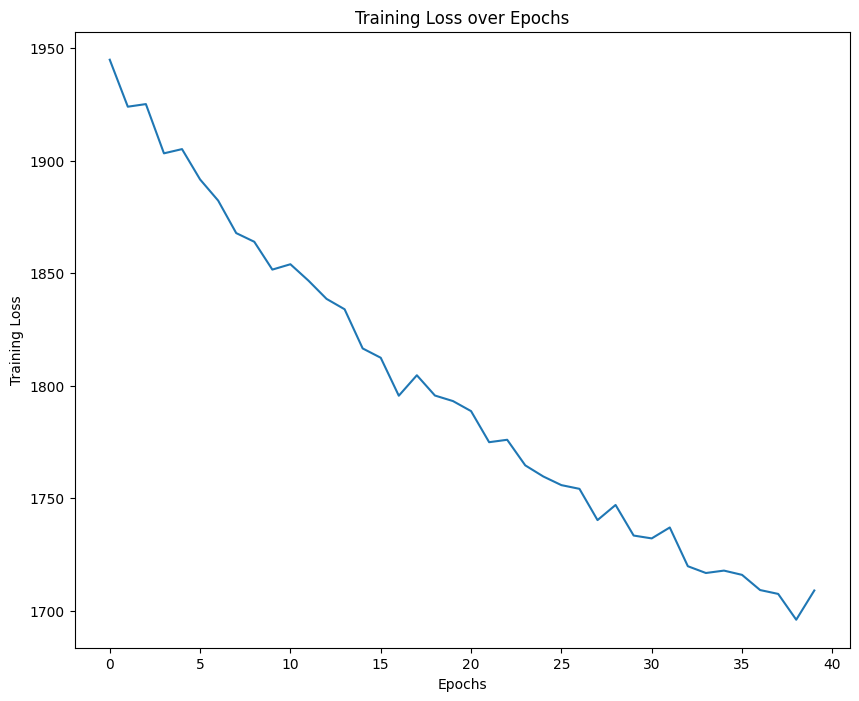

In [13]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.0005)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []
num_epochs = 400
batch_size = 256
num_batches = num_points // batch_size

## batching is done in order to make the training more effecient 
dataset = tf.data.Dataset.from_tensor_slices((x_initial_bc, y_initial_bc, t_initial_bc, u_initial_bc))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Training loop
for itr in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataset:
        x_batch, y_batch, t_batch, u_batch = batch
        with tf.GradientTape() as tape:
            train_loss = loss_pde(x_batch, y_batch, t_batch, NNQ6) + ic_bc_loss(x_batch, y_batch, t_batch, NNQ6, u_batch)
        
        grad_w = tape.gradient(train_loss, NNQ6.trainable_variables)
        optm.apply_gradients(zip(grad_w, NNQ6.trainable_variables))
        
        # Accumulate the loss for each batch
        epoch_loss += train_loss
        num_batches += 1
    
    # Compute the average loss over all batches
    epoch_loss /= num_batches
    
    if itr % 10 == 0:
        train_loss_record.append(epoch_loss)
        print(f"Epoch {itr}: Average Loss = {epoch_loss.numpy()}")

plt.figure(figsize = (10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

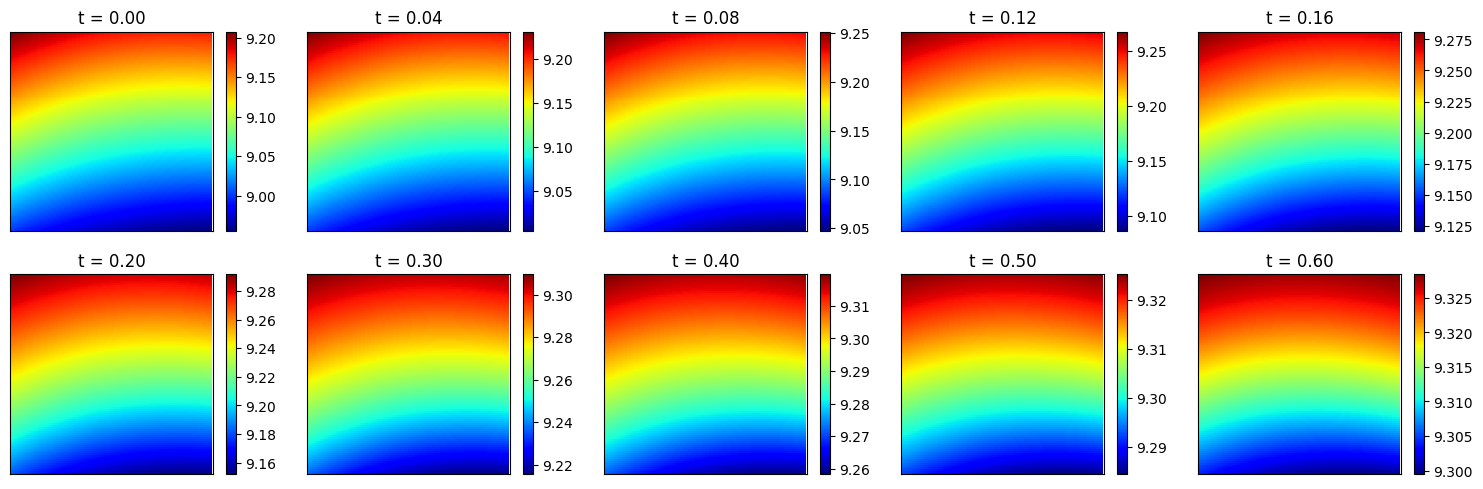

In [14]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
# NN= NNClassical
# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NNQ6(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()

## Circuit 7

In [16]:
qlayer7 = quantum_layer(n_qubits = 4, circuit_number='7')

NNQ7 = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    qlayer7,
    tf.keras.layers.Lambda(complex_to_real),  # Lambda layer to split complex numbers
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NNQ7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 32)                128       
                                                                 
 dense_24 (Dense)            (None, 32)                1056      
                                                                 
 dense_25 (Dense)            (None, 4)                 132       
                                                                 
 keras_layer_4 (KerasLayer)  (None, 4)                 20        
                                                                 
 lambda_3 (Lambda)           (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 4)                 36        
                                                                 
 dense_27 (Dense)            (None, 1)                

Epoch 0: Average Loss = 1975.377197265625
Epoch 10: Average Loss = 1941.3304443359375
Epoch 20: Average Loss = 1924.3238525390625
Epoch 30: Average Loss = 1911.7796630859375
Epoch 40: Average Loss = 1890.94140625
Epoch 50: Average Loss = 1871.4605712890625
Epoch 60: Average Loss = 1865.7396240234375
Epoch 70: Average Loss = 1854.9345703125
Epoch 80: Average Loss = 1832.4033203125
Epoch 90: Average Loss = 1827.4986572265625
Epoch 100: Average Loss = 1836.414794921875
Epoch 110: Average Loss = 1806.867431640625
Epoch 120: Average Loss = 1810.2847900390625
Epoch 130: Average Loss = 1800.0908203125
Epoch 140: Average Loss = 1795.6123046875
Epoch 150: Average Loss = 1779.7513427734375
Epoch 160: Average Loss = 1775.836181640625
Epoch 170: Average Loss = 1773.1832275390625
Epoch 180: Average Loss = 1760.2744140625
Epoch 190: Average Loss = 1765.2916259765625
Epoch 200: Average Loss = 1754.886962890625
Epoch 210: Average Loss = 1749.8258056640625
Epoch 220: Average Loss = 1751.072021484375
Ep

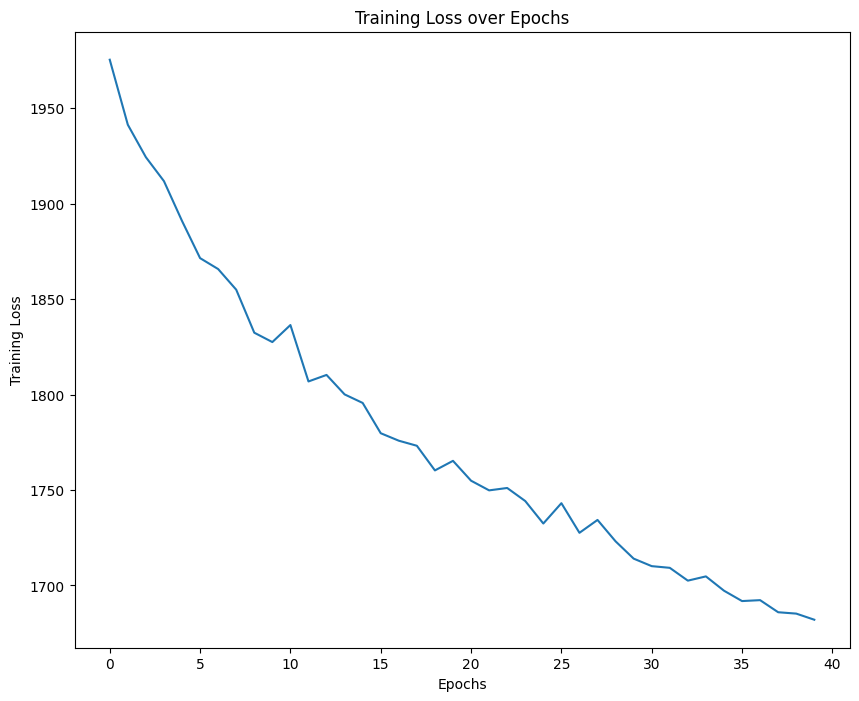

In [17]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.0005)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []
num_epochs = 400
batch_size = 256
num_batches = num_points // batch_size

## batching is done in order to make the training more effecient 
dataset = tf.data.Dataset.from_tensor_slices((x_initial_bc, y_initial_bc, t_initial_bc, u_initial_bc))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Training loop
for itr in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataset:
        x_batch, y_batch, t_batch, u_batch = batch
        with tf.GradientTape() as tape:
            train_loss = loss_pde(x_batch, y_batch, t_batch, NNQ7) + ic_bc_loss(x_batch, y_batch, t_batch, NNQ7, u_batch)
        
        grad_w = tape.gradient(train_loss, NNQ7.trainable_variables)
        optm.apply_gradients(zip(grad_w, NNQ7.trainable_variables))
        
        # Accumulate the loss for each batch
        epoch_loss += train_loss
        num_batches += 1
    
    # Compute the average loss over all batches
    epoch_loss /= num_batches
    
    if itr % 10 == 0:
        train_loss_record.append(epoch_loss)
        print(f"Epoch {itr}: Average Loss = {epoch_loss.numpy()}")

plt.figure(figsize = (10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

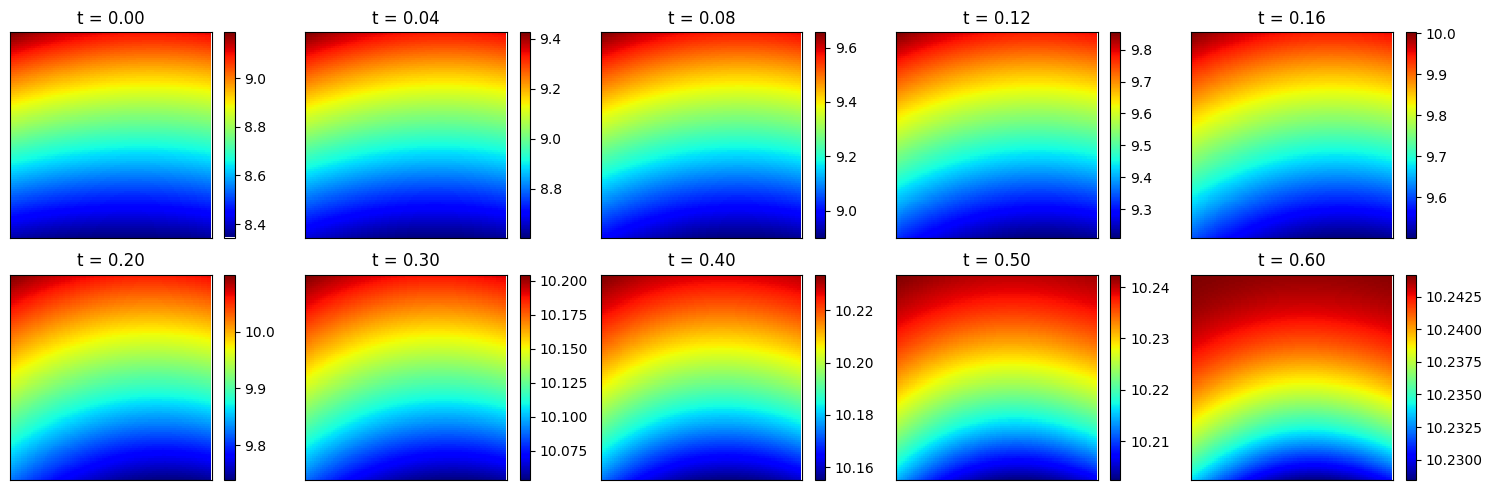

In [18]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
# NN= NNClassical
# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NNQ7(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()

## Circuit 14

In [19]:
qlayer14 = quantum_layer(n_qubits = 4, circuit_number='14')

NNQ14 = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    qlayer14,
    tf.keras.layers.Lambda(complex_to_real),  # Lambda layer to split complex numbers
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NNQ14.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                128       
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 4)                 132       
                                                                 
 keras_layer_5 (KerasLayer)  (None, 4)                 16        
                                                                 
 lambda_4 (Lambda)           (None, 8)                 0         
                                                                 
 dense_31 (Dense)            (None, 4)                 36        
                                                                 
 dense_32 (Dense)            (None, 1)                

Epoch 0: Average Loss = 1950.936767578125
Epoch 10: Average Loss = 1938.4560546875
Epoch 20: Average Loss = 1917.168212890625
Epoch 30: Average Loss = 1888.1822509765625
Epoch 40: Average Loss = 1878.120849609375
Epoch 50: Average Loss = 1875.265869140625
Epoch 60: Average Loss = 1862.459228515625
Epoch 70: Average Loss = 1861.771484375
Epoch 80: Average Loss = 1854.0279541015625
Epoch 90: Average Loss = 1835.8648681640625
Epoch 100: Average Loss = 1833.622802734375
Epoch 110: Average Loss = 1814.2847900390625
Epoch 120: Average Loss = 1824.635498046875
Epoch 130: Average Loss = 1815.70703125
Epoch 140: Average Loss = 1795.282958984375
Epoch 150: Average Loss = 1796.5849609375
Epoch 160: Average Loss = 1793.7279052734375
Epoch 170: Average Loss = 1785.800537109375
Epoch 180: Average Loss = 1779.106201171875
Epoch 190: Average Loss = 1779.909423828125
Epoch 200: Average Loss = 1767.2646484375
Epoch 210: Average Loss = 1759.9974365234375
Epoch 220: Average Loss = 1749.800537109375
Epoch 

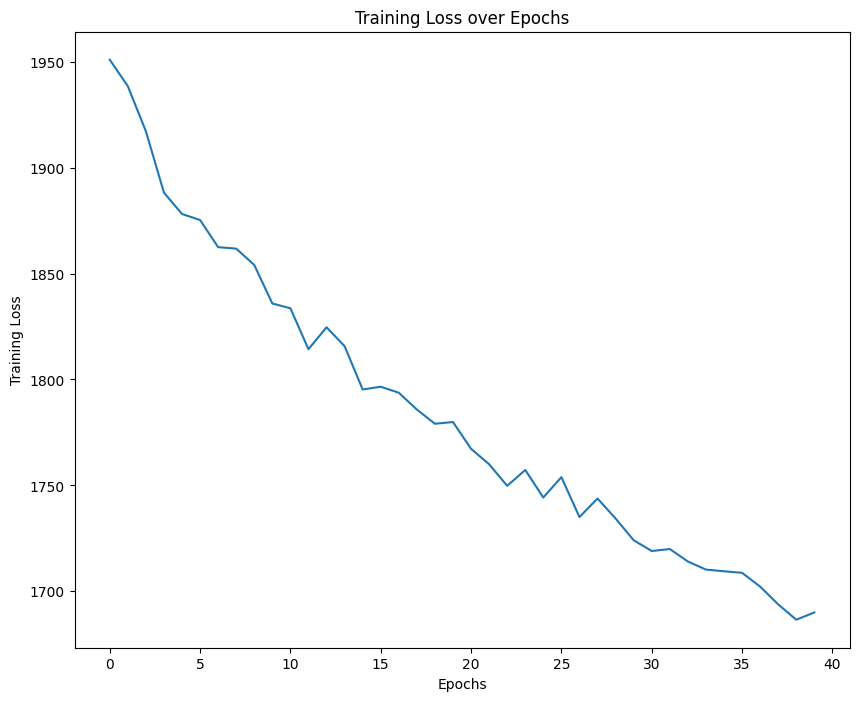

In [20]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.0005)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []
num_epochs = 400
batch_size = 256
num_batches = num_points // batch_size

## batching is done in order to make the training more effecient 
dataset = tf.data.Dataset.from_tensor_slices((x_initial_bc, y_initial_bc, t_initial_bc, u_initial_bc))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Training loop
for itr in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataset:
        x_batch, y_batch, t_batch, u_batch = batch
        with tf.GradientTape() as tape:
            train_loss = loss_pde(x_batch, y_batch, t_batch, NNQ14) + ic_bc_loss(x_batch, y_batch, t_batch, NNQ14, u_batch)
        
        grad_w = tape.gradient(train_loss, NNQ14.trainable_variables)
        optm.apply_gradients(zip(grad_w, NNQ14.trainable_variables))
        
        # Accumulate the loss for each batch
        epoch_loss += train_loss
        num_batches += 1
    
    # Compute the average loss over all batches
    epoch_loss /= num_batches
    
    if itr % 10 == 0:
        train_loss_record.append(epoch_loss)
        print(f"Epoch {itr}: Average Loss = {epoch_loss.numpy()}")

plt.figure(figsize = (10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

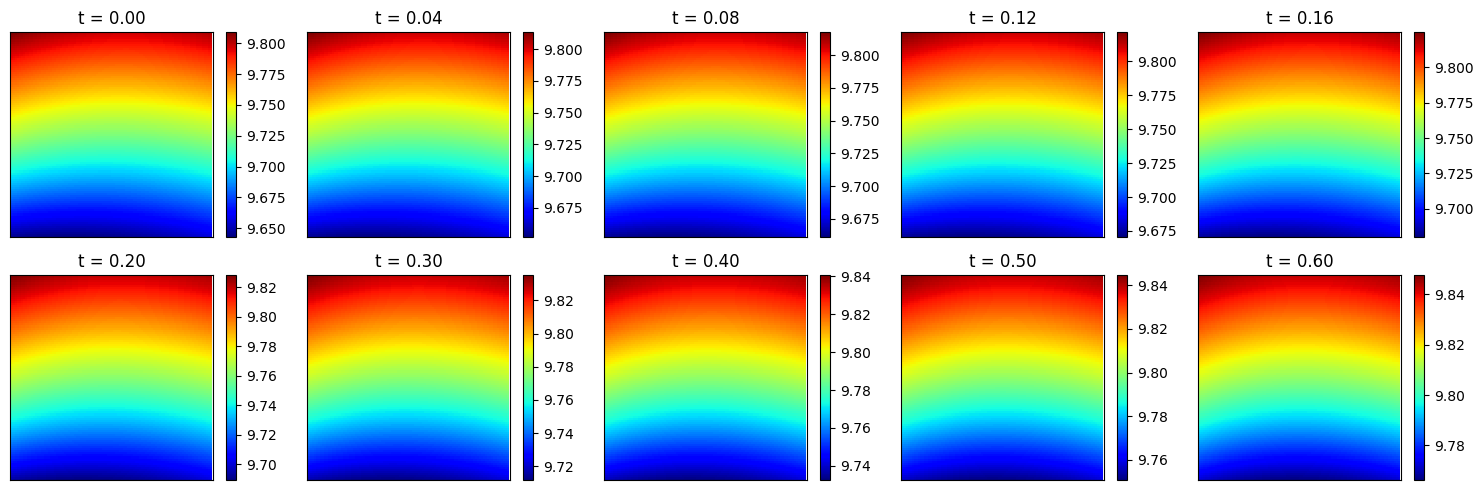

In [21]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
# NN= NNClassical
# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NNQ14(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()

# Plotting and benchmarking

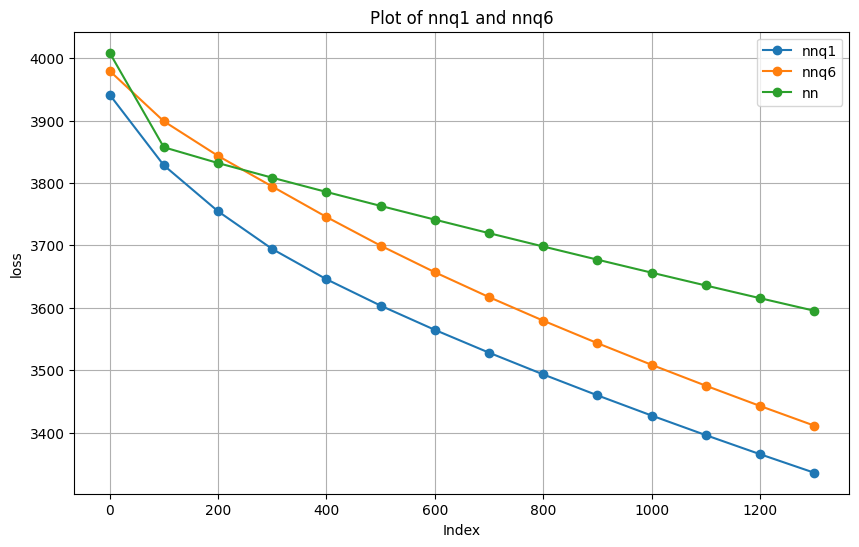

In [14]:
nnq1 = [
    3941.5862, 3828.3008, 3754.6316, 3694.221, 3645.7544, 3603.4375,
    3564.6123, 3528.0767, 3493.224, 3459.702, 3427.3162, 3395.9058,
    3365.382, 3335.6665
]
nnq6 = [
    3979.6536, 3898.9226, 3843.4438, 3794.336, 3745.5632, 3699.5696,
    3656.981, 3617.1187, 3579.3706, 3543.3108, 3508.62, 3475.1333,
    3442.6873, 3411.1753, 
]

nn = [4008.747,3857.2507,3831.9365,3808.444,3785.6218,3763.2703,
3741.2673,3719.6035,3698.2246,3677.1309,3656.293,3635.718,
3615.379,3595.281]


# X-axis values
x_values = np.arange(0,1400,100)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, nnq1, marker='o', label='nnq1')
plt.plot(x_values, nnq6, marker='o', label='nnq6')
plt.plot(x_values, nn, marker='o', label='nn')
plt.xlabel('Index')
plt.ylabel('loss')
plt.title('Plot of nnq1 and nnq6')
plt.legend()
plt.grid(True)
plt.show()